In [1]:
%reset -f
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Conv2D,Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from tensorflow.keras.models import Model
from tensorflow.keras import Input

from tensorflow.keras.datasets.mnist import load_data

# Libraires traitements données avant de s'entrainer
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale

# Libraires classique
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#fix random seed for reproductability
seed=7 #afin de toujours générer les mêmes nombres aléatoires 
np.random.seed(seed)
n_samples= 128
latent_dim = 100
Niter = 10000
lr1 = 0.001
lr2 = 0.0001

In [3]:
(X_train, y_train ), ( X_test , y_test ) = load_data()
X_train.shape

(60000, 28, 28)

In [4]:
X_train = X_train[:50000,:,:]
X_val = X_train[50000:,:,:]

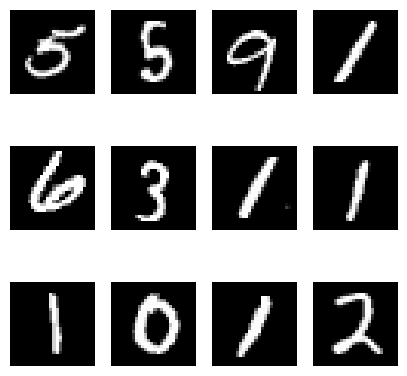

In [5]:
# Create a figure with 3x3 subplots
fig, axes = plt.subplots(3, 4, figsize=(5, 5))
# Loop through the images and display them in the subplots
for i, ax in enumerate(axes.ravel()):
    idx = np.random.randint(0,X_train.shape[0] - 1)
    ax.imshow(X_train[idx], cmap = 'gray')
    ax.axis('off')
plt.show()

In [6]:
def sampling(mu_sig):
    dim = tf.shape(mu_sig[0])
    epsi = tf.random.normal(dim)
    z = mu_sig[0] + mu_sig[1]*epsi
    return z

In [7]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_train = X_train/255.0
print(X_train.shape)

X_val = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]))
X_val = X_val/255.0
print(X_val.shape)

(50000, 784)
(0, 784)


In [8]:
#encodeur
x0_encoder = Input(shape = 784)
x1_encoder = Dense(256, activation = 'relu')(x0_encoder)
mu = Dense(2)(x1_encoder)
sigma = Dense(2)(x1_encoder)
z = Lambda(sampling)([mu,sigma])

encoder = Model(inputs = x0_encoder, outputs = [mu, sigma, z])

# décodeur
x0_decoder = Input(shape = 2)
x1_decoder = Dense(256, activation = 'relu')(x0_decoder)
x2_decoder = Dense(784, activation='sigmoid')(x1_decoder)

decoder = Model(inputs = x0_decoder, outputs = x2_decoder)

# VAE
vae = Model(inputs = x0_encoder, outputs = decoder(encoder(x0_encoder)[2]))

# loss VAE
reconstruction_loss=tf.keras.losses.mse(x0_encoder,decoder(encoder(x0_encoder)[2])) #y_true, y_pred

mu_loss=tf.math.square(mu)
mu_loss=tf.reduce_mean(mu_loss) #(1/N)*sum(mu²)=||mu||²

sigma_loss=tf.math.square(sigma-1)
sigma_loss=tf.reduce_mean(sigma_loss) #(1/N)*sum((sigma-1)²)=||sigma-1||²

loss=1000*reconstruction_loss+mu_loss+sigma_loss

vae.add_loss(loss)

encoder.summary()
decoder.summary()
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense[0][0]                      
______________________________________________________________________________________________

In [9]:
vae.compile(optimizer = 'adam')

In [10]:
hist = vae.fit(X_train,X_train,epochs=10,batch_size=100,validation_data=(X_val,X_val))

Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 69.2512
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 54.7029
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 52.5968
Epoch 4/10
500/500 [==============================] - 2s 3ms/step - loss: 51.4722
Epoch 5/10
500/500 [==============================] - 2s 3ms/step - loss: 50.6048
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 49.9021
Epoch 7/10
500/500 [==============================] - 2s 4ms/step - loss: 49.3182
Epoch 8/10
500/500 [==============================] - 2s 4ms/step - loss: 48.7727
Epoch 9/10
500/500 [==============================] - 2s 4ms/step - loss: 48.2747
Epoch 10/10
500/500 [==============================] - 2s 3ms/step - loss: 47.8193


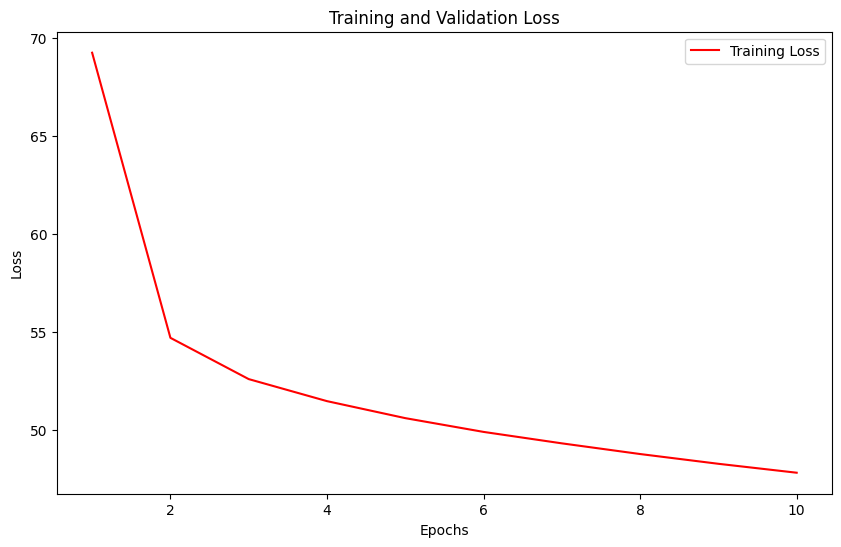

In [11]:
train_loss = hist.history['loss']
#val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'r', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

X_test = X_test/255.0

In [13]:
pred = vae.predict(X_test) 
pred = pred*255.0

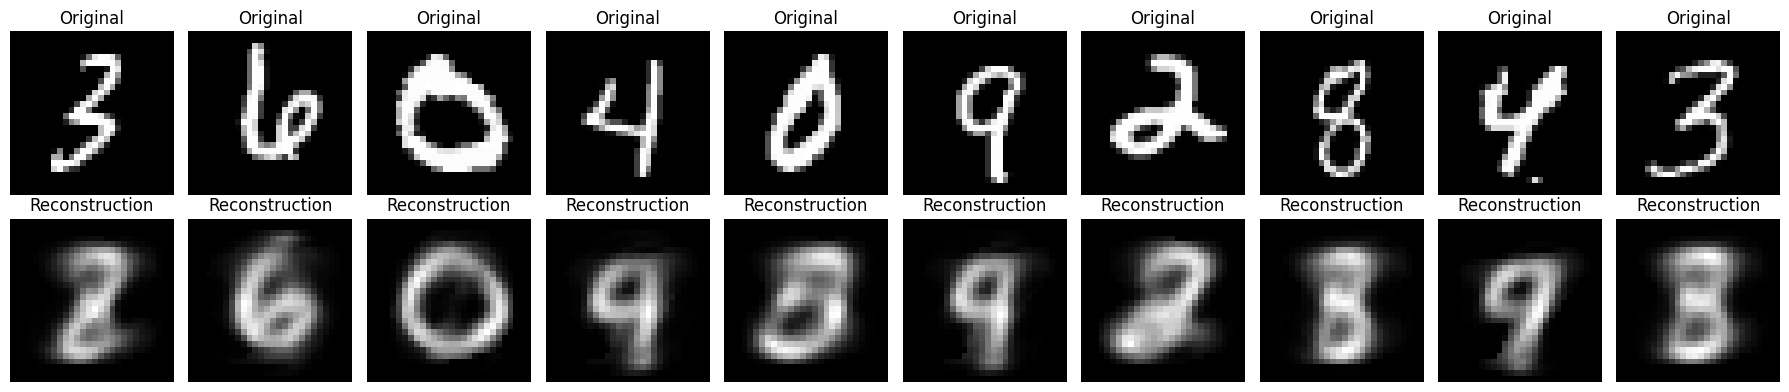

In [14]:
# Utiliser l'autoencodeur pour obtenir des reconstructions des données de test
reconstructed_images = vae.predict(X_test)

# Choisir un échantillon d'images de test à afficher
num_images_to_display = 10
random_indices = np.random.choice(range(len(X_test)), num_images_to_display)

# Afficher les images originales et leurs reconstructions
plt.figure(figsize=(18, 4))
for i, image_index in enumerate(random_indices):
    # Image originale
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(X_test[image_index].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstruction
    plt.subplot(2, num_images_to_display, i + 1 + num_images_to_display)
    plt.imshow(reconstructed_images[image_index].reshape(28, 28), cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')

plt.tight_layout()
plt.show()

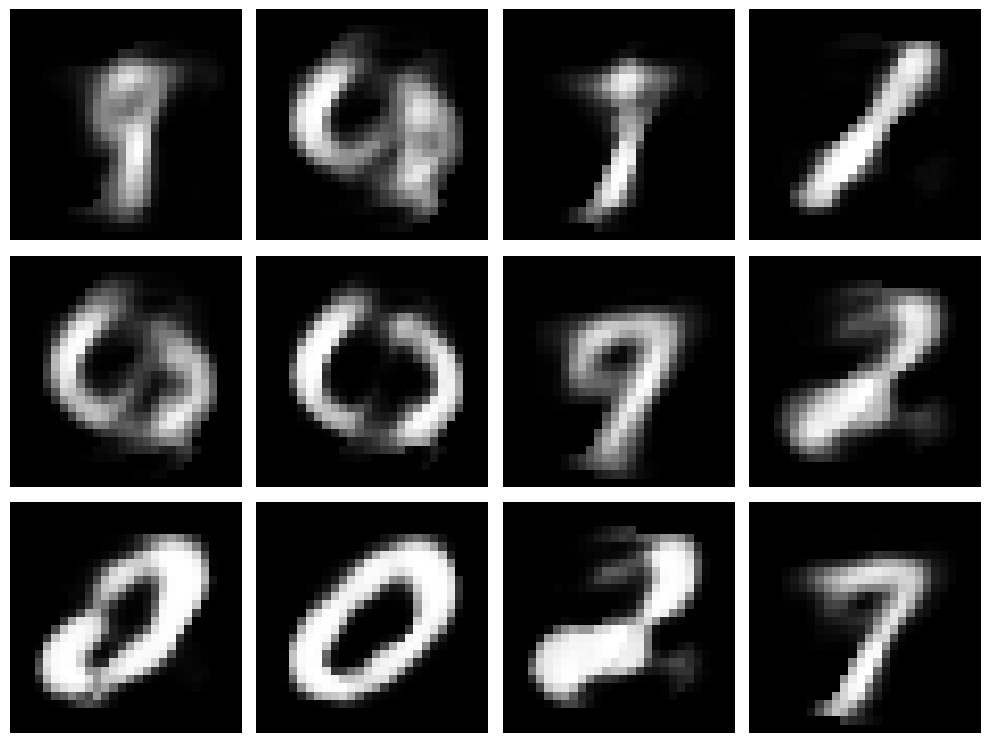

In [15]:
# Générer de nouveaux individus
num_samples = 12
# Nombre d'individus à générer
latent_space_samples = np.random.normal(size=(num_samples, 2))  # Générer des échantillons dans l'espace latent
generated_images = decoder.predict(latent_space_samples)


plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
z = encoder(X_test)
print(np.array(z[2]))
print(np.array(z[2]).shape)

[[ 1.3723072  -0.5085954 ]
 [-0.29305395  0.33151385]
 [ 0.7376483   1.2457589 ]
 ...
 [ 0.9994013  -0.36263216]
 [ 0.20851837  0.20288327]
 [-0.3179731  -0.42969435]]
(10000, 2)


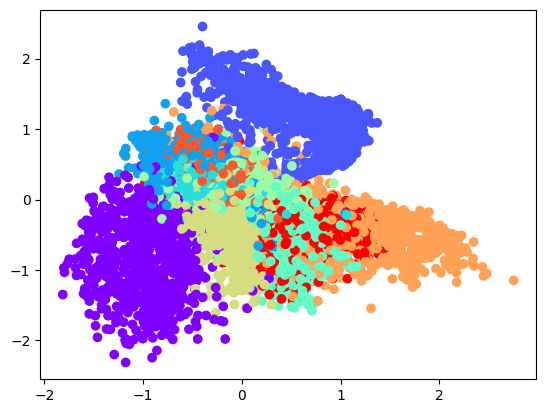

In [17]:
u = np.array(z[2])[:,0]
v = np.array(z[2])[:,1]
plt.figure(figsize = (20,20))
plt.scatter(u,v,c = y_test, cmap = 'rainbow')
plt.title('La présentation de l espace latent')
plt.show()